In [542]:
import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from robin_helperfunctions import round_to_hour
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.optimizers import SGD
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Conv1D, MaxPooling1D
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from lstmPrice_Prediction import PricePrediction
from keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

### Load in Data and Clean:

In [506]:
# from coinapi_rest_v1 import CoinAPIv1
# from robin_helperfunctions import round_to_hour
# from logins import CoinAPI_KEY
# coin_api = CoinAPIv1(CoinAPI_KEY)
# symbol = 'KRAKEN_SPOT_ETH_USD'
# agg = '4HRS'
# hours_of_data = 100000
# now = str(pd.Timestamp.today())[0:16]
# time_window = round_to_hour(pd.Timestamp.today() - datetime.timedelta(hours=hours_of_data)).isoformat()
# df = pd.DataFrame(coin_api.ohlcv_historical_data(symbol, {'period_id':agg, 'time_start':time_window, 'limit':'100000'})).set_index('time_period_start')
# df.to_csv('eth_historical_4hrs.csv')

# Load historical data from file:
df = pd.read_csv('eth_historical_4hrs.csv')

# Convert timezones and reformat:
df['time_period_start'] = pd.to_datetime(df['time_period_start']).dt.tz_convert('US/Central').dt.strftime('%m-%d-%Y %H:%M')
# Reset Index
df.set_index('time_period_start', inplace=True)
# Pull just the value fields:
df = df[['price_open', 'price_high', 'price_low', 'price_close']]
df.head()

,price_open,price_high,price_low,price_close
time_period_start,,,,
10-17-2016 07:00,11.87000,11.90000,11.85972,11.8895
10-17-2016 11:00,11.89000,12.00000,11.89000,12.0000
10-17-2016 15:00,12.00000,12.03000,11.93356,12.0300
10-17-2016 19:00,12.02591,12.20000,12.00000,12.2000
10-17-2016 23:00,12.20000,12.54799,12.20000,12.4310


In [507]:
df.iloc[-6:].values

array([[344.41, 355.41, 340.8 , 353.15],
       [353.48, 359.9 , 348.35, 352.51],
       [352.5 , 358.5 , 344.1 , 348.3 ],
       [347.95, 351.55, 337.26, 343.44],
       [343.46, 349.46, 332.31, 335.77],
       [335.71, 341.35, 323.4 , 338.1 ]])

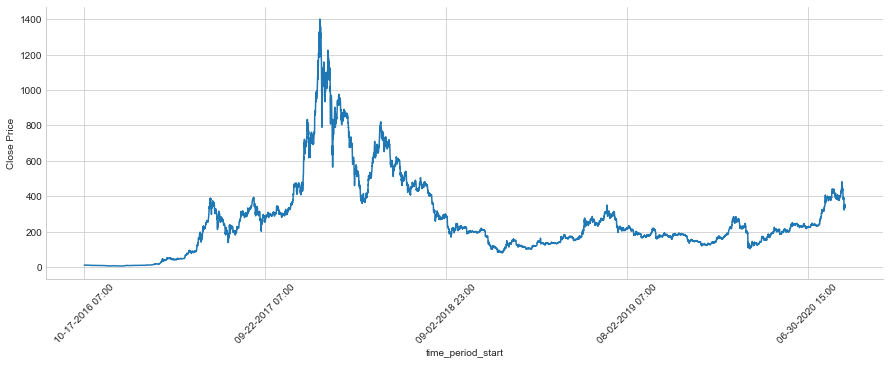

In [508]:
# Plot the closing prices just as a reference:
df['price_close'].plot(figsize=(15,5))
plt.ylabel('Close Price')
plt.xticks(rotation=45)
sns.despine()
plt.show()

### Prepare Data for Modeling

In [509]:
lookforward_num = 6

df_modeling = df.copy()
df_modeling['6prd_pctchange'] = df_modeling[['price_close']].pct_change(lookforward_num)

In [510]:
df_modeling.head(10)

,price_open,price_high,price_low,price_close,6prd_pctchange
time_period_start,,,,,
10-17-2016 07:00,11.87000,11.90000,11.85972,11.88950,NaN
10-17-2016 11:00,11.89000,12.00000,11.89000,12.00000,NaN
10-17-2016 15:00,12.00000,12.03000,11.93356,12.03000,NaN
10-17-2016 19:00,12.02591,12.20000,12.00000,12.20000,NaN
10-17-2016 23:00,12.20000,12.54799,12.20000,12.43100,NaN
10-18-2016 03:00,12.39040,12.59809,12.31003,12.53369,NaN
10-18-2016 07:00,12.53369,12.89950,12.48000,12.73950,0.071492
10-18-2016 11:00,12.65747,12.79000,12.51000,12.59420,0.049517
10-18-2016 15:00,12.59239,12.59840,12.44000,12.48257,0.037620


In [511]:
def entry_flag(df, lookforward_num):
    entry_flags = []
    for i in range(len(df_modeling) - lookforward_num):
        if df_modeling.iloc[i+lookforward_num]['6prd_pctchange'] >= 0.05:
            entry_flags.append(1)
#         elif df_modeling.iloc[i+lookforward_num]['6prd_pctchange'] <= 0:
#             entry_flags.append(0)
        else:
            entry_flags.append(0)
    for i in range(lookforward_num):
        entry_flags.append(None)
    return entry_flags

In [512]:
df_modeling['entry_flag'] = entry_flag(df_modeling, lookforward_num)

In [515]:
df_modeling['26_ema'] = df_modeling['price_close'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
df_modeling['12_ema'] = df_modeling['price_close'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
df_modeling['MACD'] = df_modeling['12_ema'] - df_modeling['26_ema']
df_modeling = df_modeling.fillna(0)

df_modeling['HL'] = df_modeling['price_high'] - df_modeling['price_low']
df_modeling['absHC'] = abs(df_modeling['price_high'] - df_modeling['price_close'].shift(1))
df_modeling['absLC'] = abs(df_modeling['price_low'] - df_modeling['price_close'].shift(1))
df_modeling['TR'] = df_modeling[['HL','absHC','absLC']].max(axis=1)
df_modeling['ATR'] = df_modeling['TR'].rolling(window=14).mean()
df_modeling['NATR'] = (df_modeling['ATR'] / df_modeling['price_close']) *100
df_modeling = df_modeling.fillna(0)

def DMI(df, period):
    df['UpMove'] = df['price_high'] - df['price_high'].shift(1)
    df['DownMove'] = df['price_low'].shift(1) - df['price_low']
    df['Zero'] = 0

    df['PlusDM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > df['Zero']), df['UpMove'], 0)
    df['MinusDM'] = np.where((df['UpMove'] < df['DownMove']) & (df['DownMove'] > df['Zero']), df['DownMove'], 0)

    df['plusDI'] = 100 * (df['PlusDM']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()
    df['minusDI'] = 100 * (df['MinusDM']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()

    df['ADX'] = 100 * (abs((df['plusDI'] - df['minusDI'])/(df['plusDI'] + df['minusDI']))).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()

DMI(df_modeling, 14)
df_modeling.fillna(0, inplace=True)

In [516]:
df_modeling.head(10)

,price_open,price_high,price_low,price_close,6prd_pctchange,entry_flag,26_ema,12_ema,MACD,HL,...,ATR,NATR,UpMove,DownMove,Zero,PlusDM,MinusDM,plusDI,minusDI,ADX
time_period_start,,,,,,,,,,,,,,,,,,,,,
10-17-2016 07:00,11.87000,11.90000,11.85972,11.88950,0.000000,1.0,11.889500,11.889500,0.000000,0.04028,...,0.0,0.0,0.00000,0.00000,0,0.00000,0.00,0.0,0.0,0.0
10-17-2016 11:00,11.89000,12.00000,11.89000,12.00000,0.000000,0.0,11.946875,11.949354,0.002479,0.11000,...,0.0,0.0,0.10000,-0.03028,0,0.10000,0.00,0.0,0.0,0.0
10-17-2016 15:00,12.00000,12.03000,11.93356,12.03000,0.000000,0.0,11.976741,11.980830,0.004089,0.09644,...,0.0,0.0,0.03000,-0.04356,0,0.03000,0.00,0.0,0.0,0.0
10-17-2016 19:00,12.02591,12.20000,12.00000,12.20000,0.000000,0.0,12.039154,12.050014,0.010859,0.20000,...,0.0,0.0,0.17000,-0.06644,0,0.17000,0.00,0.0,0.0,0.0
10-17-2016 23:00,12.20000,12.54799,12.20000,12.43100,0.000000,0.0,12.130025,12.153526,0.023501,0.34799,...,0.0,0.0,0.34799,-0.20000,0,0.34799,0.00,0.0,0.0,0.0
10-18-2016 03:00,12.39040,12.59809,12.31003,12.53369,0.000000,0.0,12.210876,12.245926,0.035050,0.28806,...,0.0,0.0,0.05010,-0.11003,0,0.05010,0.00,0.0,0.0,0.0
10-18-2016 07:00,12.53369,12.89950,12.48000,12.73950,0.071492,0.0,12.304889,12.356065,0.051176,0.41950,...,0.0,0.0,0.30141,-0.16997,0,0.30141,0.00,0.0,0.0,0.0
10-18-2016 11:00,12.65747,12.79000,12.51000,12.59420,0.049517,0.0,12.351504,12.405760,0.054256,0.28000,...,0.0,0.0,-0.10950,-0.03000,0,0.00000,0.00,0.0,0.0,0.0
10-18-2016 15:00,12.59239,12.59840,12.44000,12.48257,0.037620,0.0,12.370931,12.420956,0.050025,0.15840,...,0.0,0.0,-0.19160,0.07000,0,0.00000,0.07,0.0,0.0,0.0


### Convert to Sequences

In [517]:
len(y_train)

6724

In [518]:
train_set

,price_open,price_high,price_low,price_close,entry_flag
time_period_start,,,,,
10-17-2016 07:00,11.87000,11.90000,11.85972,11.8895,1.0
10-17-2016 11:00,11.89000,12.00000,11.89000,12.0000,0.0
10-17-2016 15:00,12.00000,12.03000,11.93356,12.0300,0.0
10-17-2016 19:00,12.02591,12.20000,12.00000,12.2000,0.0
10-17-2016 23:00,12.20000,12.54799,12.20000,12.4310,0.0
...,...,...,...,...,...
12-01-2019 02:00,147.01000,148.45000,146.05000,147.4000,0.0
12-01-2019 06:00,147.39000,152.49000,147.39000,149.3800,0.0
12-01-2019 10:00,149.47000,150.51000,149.15000,149.9600,0.0


In [519]:
lstm = PricePrediction()
lstm.load_dataframe(df_modeling)
train_set, test_set = lstm.split_data()

n_input = 6
n_out = 1

y_train = np.array(train_set['entry_flag'].values.tolist()[n_input:])
X_train = lstm.to_supervised_classification(train_set.drop(columns=['entry_flag']), n_input, n_out)
y_test = np.array(test_set['entry_flag'][n_input:])
X_test = lstm.to_supervised_classification(test_set.drop(columns=['entry_flag']), n_input, n_out)

In [520]:
def normalized_df(X):
    scaler = MinMaxScaler()
    # transform data
    return np.array([scaler.fit_transform(x) for x in X])

In [521]:
X_train_norm = normalized_df(X_train)
X_test_norm = normalized_df(X_test)

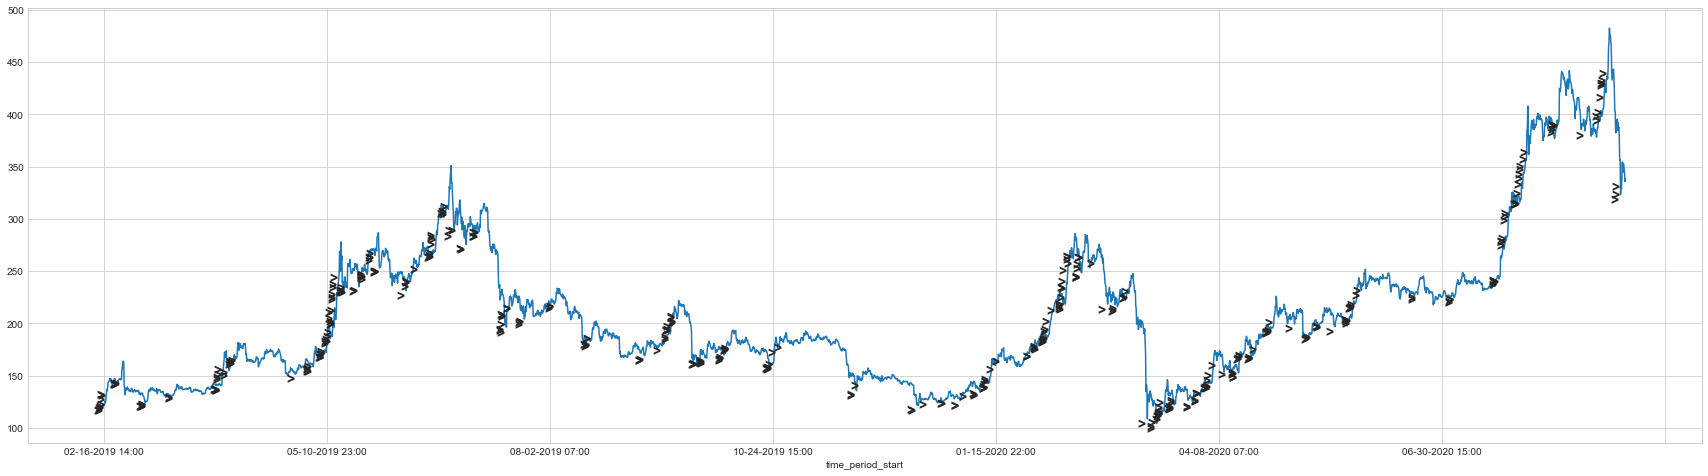

In [522]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(30,8))

df_plot = df_modeling[5000:]

df_plot['price_close'].plot()

for i in range(len(df_plot)):
    if df_plot.iloc[i, 5] == 1:
        plt.annotate('>', (i, df_plot.iloc[i]['price_close']), xytext=(-10, -10), textcoords='offset points', fontsize=14, fontweight='bold')

# plt.scatter(self.trades['trade_start'], self.trades['buy_price'], marker='^',s=70, color='green')
# plt.scatter(self.trades['trade_end'], self.trades['sell_price'], marker='v',s=70, color='red')

___
### Old Code:

In [551]:
neurons = 1024               # number of hidden units in the LSTM layer
activation_function = 'sigmoid'  # activation function for LSTM and Dense layer
loss = 'binary_crossentropy'  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer = keras.optimizers.SGD(learning_rate=0.0001)        # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 56


model = Sequential()
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 

In [552]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
results = model.fit(X_train_norm, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_norm, y_test), shuffle=False)

Epoch 1/56
53/53 [==============================] - 1s 12ms/step - loss: 0.7498 - accuracy: 0.1505 - val_loss: 0.7502 - val_accuracy: 0.1151
Epoch 2/56
53/53 [==============================] - 0s 6ms/step - loss: 0.7422 - accuracy: 0.1511 - val_loss: 0.7419 - val_accuracy: 0.1157
Epoch 3/56
53/53 [==============================] - 0s 7ms/step - loss: 0.7348 - accuracy: 0.1557 - val_loss: 0.7339 - val_accuracy: 0.1258
Epoch 4/56
53/53 [==============================] - 0s 7ms/step - loss: 0.7276 - accuracy: 0.1657 - val_loss: 0.7260 - val_accuracy: 0.1497
Epoch 5/56
53/53 [==============================] - 0s 7ms/step - loss: 0.7206 - accuracy: 0.1868 - val_loss: 0.7183 - val_accuracy: 0.1825
Epoch 6/56
53/53 [==============================] - 0s 6ms/step - loss: 0.7137 - accuracy: 0.2287 - val_loss: 0.7109 - val_accuracy: 0.2433
Epoch 7/56
53/53 [==============================] - 0s 7ms/step - loss: 0.7070 - accuracy: 0.2876 - val_loss: 0.7036 - val_accuracy: 0.3453
Epoch 8/56
53/53 [=

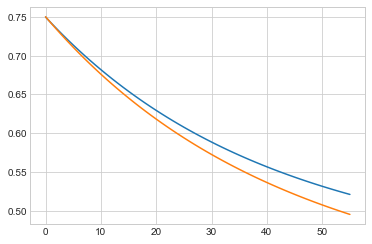

In [554]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])

### Prediction Analysis

In [555]:
predictions = model.predict(X_test_norm)
predictions_round = [1 if x > 0.5 else 0 for x in predictions]

In [556]:
df_predict = test_set[6:]
df_predict['predictions']= predictions_round

In [560]:
df_plot['predictions'].value_counts()

0    1677
Name: predictions, dtype: int64

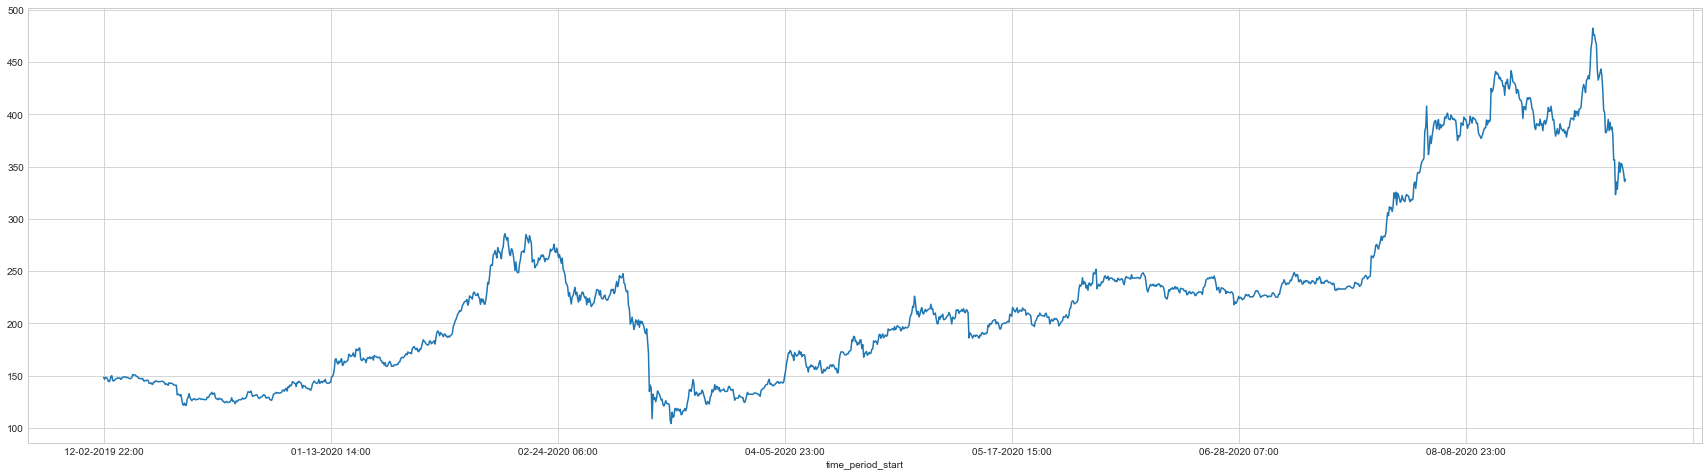

In [557]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(30,8))

df_plot = df_predict

df_plot['price_close'].plot()

for i in range(len(df_plot)):
    if df_plot.iloc[i, 23] == 1:
        plt.annotate('>', (i, df_plot.iloc[i]['price_close']), xytext=(-10, 0), textcoords='offset points', fontsize=14, fontweight='bold')

In [536]:
df_plot

,price_open,price_high,price_low,price_close,6prd_pctchange,entry_flag,26_ema,12_ema,MACD,HL,...,NATR,UpMove,DownMove,Zero,PlusDM,MinusDM,plusDI,minusDI,ADX,predictions
time_period_start,,,,,,,,,,,,,,,,,,,,,
12-02-2019 22:00,149.34,149.60,148.00,148.31,-0.000808,0.0,149.933073,149.124161,-0.808912,1.60,...,1.740563,-0.35,0.60,0,0.00,0.60,11.493428,16.948944,21.318518,0
12-03-2019 02:00,148.31,148.98,145.08,146.65,-0.014051,0.0,149.689882,148.743520,-0.946362,3.90,...,1.670644,-0.62,2.92,0,0.00,2.92,9.960971,30.580241,25.257386,0
12-03-2019 06:00,146.74,149.09,146.57,148.34,-0.001077,0.0,149.589891,148.681440,-0.908450,2.52,...,1.680502,0.11,-1.49,0,0.11,0.00,9.221189,26.502876,28.339798,0
12-03-2019 10:00,148.26,148.78,147.74,148.04,0.001963,0.0,149.475084,148.582757,-0.892327,1.04,...,1.618288,-0.31,-1.17,0,0.00,0.00,7.991697,22.969159,31.011222,0
12-03-2019 14:00,147.80,148.20,147.20,147.37,-0.009943,0.0,149.319152,148.396179,-0.922973,1.00,...,1.426923,-0.58,0.54,0,0.00,0.54,6.926137,23.330518,34.105383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09-06-2020 15:00,353.48,359.90,348.35,352.51,0.051076,0.0,375.015688,355.550931,-19.464757,11.55,...,5.848466,4.49,-7.55,0,4.49,0.00,13.172203,21.810195,49.042559,0
09-06-2020 19:00,352.50,358.50,344.10,348.30,0.060403,0.0,373.036748,354.435403,-18.601345,14.40,...,5.867684,-1.40,4.25,0,0.00,4.25,11.415909,21.674898,46.637222,0
09-06-2020 23:00,347.95,351.55,337.26,343.44,0.008220,0.0,370.844396,352.743803,-18.100594,14.29,...,6.071969,-6.95,6.84,0,0.00,6.84,9.893788,23.158264,45.769869,0


In [529]:
df_filtered = df_predict[['price_close', 'entry_flag', 'predictions']]

In [532]:
df_filtered[df_filtered['predictions'] == 1]

,price_close,entry_flag,predictions
time_period_start,,,


In [531]:
model.save('4hr_6period_lstm.h5')